In [2]:
!pip install fake_useragent
!pip install pyopenssl ndg-httpsclient pyasn1

In [6]:
import re
import requests
import fake_useragent
import pandas as pd
import time
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from os import name
from bs4 import BeautifulSoup
from randan.descriptive_statistics import ScaleStatistics

In [187]:
def get_links(text):
    ua =fake_useragent.UserAgent()
    res = requests.get(
        url=f"https://hh.ru/search/resume?area=113&relocation=living_or_relocation&gender=unknown&text={text}&isDefaultArea=true&exp_period=all_time&logic=normal&pos=full_text&fromSearchLine=false&search_period=0",
        headers={"user-agent":ua.random}
    )
    if res.status_code != 200:
        return
    soup = BeautifulSoup(res.content, "lxml")
    try:
        page_count = int(soup.find("div",attrs={"class":"pager"}).find_all("span",recursive=False)[-1].find("a").find("span").text)
    except:
        return
    for page in range(page_count):
        try:
            res = requests.get(
                url=f"https://hh.ru/search/resume?area=113&relocation=living_or_relocation&gender=unknown&text={text}&isDefaultArea=true&exp_period=all_time&logic=normal&pos=full_text&fromSearchLine=false&search_period=0&page={page}",
                headers={"user-agent":ua.random}
            )
            if res.status_code == 200:
                soup = BeautifulSoup(res.content, "lxml")
                for a in soup.find_all("a",attrs={"class":"resume-search-item__name"}):
                    yield f'https://hh.ru{a.attrs["href"].split("?")[0]}'
        except Exception as e:
            print(f"{e}")
        time.sleep(1)
    print(page_count)

In [188]:
def get_resume(link):
    ua = fake_useragent.UserAgent()
    data = requests.get(
        url=link,
        headers={"user-agent":ua.random}
    )
    if data.status_code != 200:
        return
    soup = BeautifulSoup(data.content, "lxml")
    try:
        name = soup.find(attrs={"class":"resume-block__title-text"}).text
    except:
        name = ""
    try:
        spec = soup.find_all("div", attrs={"class":"bloko-gap bloko-gap_bottom"})[1].text
    except:
        spec = []
    try:
        salary = soup.find(attrs={"class":"resume-block__title-text_salary"}).text.replace("\u2009","").replace("\xa0"," ")
    except:
        salary = ""
    try:
        exp = soup.find(attrs={"class":"resume-block__title-text resume-block__title-text_sub"}).text.replace("&nbsp;","").replace("\xa0"," ")
    except:
        exp = ""
    try:
        tags = [tag.text for tag in soup.find(attrs={"class":"bloko-tag-list"}).find_all("span",attrs={"class":"bloko-tag__section_text"})]
    except:
        tags = []
    resume = {
        "name":name,
        "salary":salary,
        "specialisation":spec,
        "experience":exp,
        "tags":tags,
    }
    return resume

In [189]:
if __name__ == "__main__":
    data1 = []
    for a in get_links("журналист"):
        data1.append(get_resume(a))
        time.sleep(1)
        with open("data.json","w",encoding="utf-8")as f:
            json.dump(data1,f,indent = 4, ensure_ascii=False)

ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

In [191]:
df_resume1 = pd.json_normalize(data1)

In [539]:
df_resume1.to_csv('resume_data_VKR.csv')

In [245]:
res1 = df_resume1.copy()

In [475]:
res1['tags'].dropna()

0       [Журналистика, Журналистские расследования, Ко...
2       [Знаю английский язык, закончила хореографичес...
3       [Коммуникабельность, Умение расположить к себе...
5       [Репортажная фотосъемка, Фотомонтаж, Постаново...
6       [Работа с людьми, Написание статей, Редакторск...
                              ...                        
2102    [Коммуникативные способности, Способность к об...
2103                                            [MS Word]
2104    [Копирайтинг, Написание текстов, Корректура те...
2105    [Поиск информации в интернет, Грамотная речь, ...
2112    [Грамотность, Английский язык, Работа в команд...
Name: tags, Length: 1376, dtype: object

In [146]:
matchPattern = r"([^A-Z]+)([A-Z]+)"
replacePattern = r"\1 \2"
res['specialisation'] = res['specialisation'].apply(lambda x: ''.join(x[j]if j not in[i for i in range(len(x)) if x[i]!=x.lower()[i]] else ' '+x[j]for j in range(len(x))).lstrip())
res1['specialisation'] = res['specialisation'].apply(lambda x: x[14:])

In [246]:
res1['specialisation'] = res1['specialisation'].apply(lambda x: x[14:])

In [247]:
res1['spec_count'] = res1['specialisation'].apply(lambda x: sum(1 for c in x if c.isupper()))

In [248]:
ss = ScaleStatistics(res1, ['spec_count'],
                    normality_test=True)


SCALE STATISTICS SUMMARY
------------------



/Users/alla/opt/anaconda3/lib/python3.9/site-packages/randan/descriptive_statistics.py:488: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  display(self.summary().style\


,N,mode,median,mean,25%,75%,interquart. range,interquart. range (norm.),min,max,range,std,var,entropy coef.,quality var.
spec_count,2114.000,2.000,2.000,2.099,2.000,2.000,0.000,0.000,1.000,8.000,7.000,0.620,0.384,0.331,0.379



NORMALITY TESTS
------------------



/Users/alla/opt/anaconda3/lib/python3.9/site-packages/randan/descriptive_statistics.py:457: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  display(self.normality_test(self.normality_test_type).style\


,statistic,p-value
spec_count,0.438,0.000


In [200]:
tt = res1.spec_count.value_counts()

2    1707
3     231
1     141
5      12
4      10
6       5
7       5
8       3
Name: spec_count, dtype: int64

In [201]:
res1['spec_count'].value_counts()/res1['spec_count'].count()*100

2    80.747398
3    10.927152
1     6.669820
5     0.567644
4     0.473037
6     0.236518
7     0.236518
8     0.141911
Name: spec_count, dtype: float64

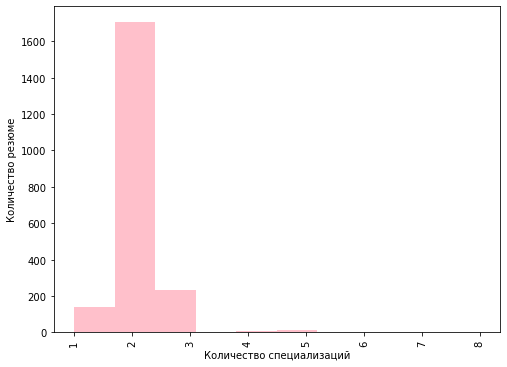

In [538]:
svar ='spec_count'

plt.figure(figsize=(8,6))
plt.hist(res1[svar].dropna(), color='pink')
plt.xticks(rotation=90)
plt.xlabel(f'Количество специализаций')
plt.ylabel('Количество резюме')
plt.savefig('spec_count.png')

In [249]:
res1['spec1'] = res1['specialisation'].apply(lambda x: x.replace(" ", ""))

In [252]:
res1['spec'] = res1['spec1'].apply(lambda x: re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z])|[а-я](?=[А-Я]))|[a-z](?=[А-Я])', r'\1 ', x).split())

In [385]:
listed11 = res11['tags'].tolist()

In [388]:
flat_list1 = [item for sublist in listed11 for item in sublist]

In [384]:
listed = res1['spec'].tolist()

In [266]:
flat_list = [item for sublist in listed for item in sublist]

In [392]:
counts = Counter(flat_list)
print(counts)

Counter({'Журналист,корреспондент': 1929, 'Режиссер,сценарист': 1902, 'Копирайтер,редактор,корректор': 274, 'Менеджерпомаркетингуирекламе': 23, 'Менеджерпопродажам,менеджерпоработесклиентами': 13, 'Продюсер': 12, 'Переводчик': 12, 'Другое': 12, 'МенеджерпомаркетингуирекламеPR-менеджер': 11, 'Учитель,преподаватель,педагог': 10, 'SMM-менеджер,контент-менеджер': 9, 'PR-менеджер': 9, 'Секретарь,помощникруководителя,ассистент': 7, 'Видеооператор,видеомонтажер': 5, 'Администратор': 5, 'Журналист,корреспондентSMM-менеджер,контент-менеджер': 5, 'Журналист,корреспондентPR-менеджер': 5, 'Director,scriptwriter': 5, 'Дизайнер,художник': 4, 'Менеджерпотуризму': 4, 's:Journalist,correspondent': 4, 'Копирайтер,редактор,корректорSMM-менеджер,контент-менеджер': 3, 'Официант,бармен,бариста': 3, 'Хостес': 3, 'Продавец-консультант,продавец-кассир': 3, 'Арт-директор,креативныйдиректор': 3, 'Фотограф,ретушер': 3, 'Копирайтер,редактор,корректорPR-менеджер': 2, 's:Director,scriptwriter': 2, 's:Interpreter': 2

In [403]:
res_specs = pd.DataFrame.from_dict(counts, orient='index').reset_index()
res_specs = res_specs.rename(columns={'index':'spec', 0:'count'})

In [412]:
res_specs['%'] = res_specs['count'].apply(lambda x: x / 2117 * 100)
res_specs = res_specs.sort_values('count', ascending=False)
res_specs.index = range(1, len(res_specs)+1)

In [536]:
res_specs.to_excel('res_specs.xlsx')

In [432]:
counts1 = Counter(flat_list1)
print(counts1)

Counter({'Написание статей': 332, 'Грамотная речь': 329, 'Написание текстов': 317, 'Пользователь ПК': 284, 'Грамотность': 258, 'Работа в команде': 233, 'Журналистика': 218, 'Креативность': 209, 'Поиск информации в интернет': 206, 'Интервьюирование': 197, 'Организаторские навыки': 160, 'Копирайтинг': 158, 'Английский язык': 147, 'Написание рекламных статей': 144, 'Работа с большим объемом информации': 129, 'Написание пресс-релизов': 120, 'Редактирование': 115, 'Деловая переписка': 111, 'Деловое общение': 109, 'Adobe Photoshop': 108, 'Ведение переговоров': 94, 'Организация мероприятий': 84, 'Корректура текстов': 84, 'MS PowerPoint': 80, 'Рерайтинг': 77, 'Литературное редактирование': 74, 'Наполнение контентом': 74, 'Ответственность': 73, 'Коммуникабельность': 72, 'Управление проектами': 63, 'Деловая коммуникация': 61, 'Редактирование текстов': 59, 'Ведение групп в социальных сетях': 58, 'Редакторская деятельность': 56, 'Фотография': 56, 'Телефонные переговоры': 56, 'Работа со СМИ': 51, '

In [434]:
res_tags = pd.DataFrame.from_dict(counts1, orient='index').reset_index()
res_tags = res_tags.rename(columns={'index':'tag', 0:'count'})

In [436]:
res_tags['%'] = res_tags['count'].apply(lambda x: x / 2117 * 100)
res_tags = res_tags.sort_values('count', ascending=False)
res_tags.index = range(1, len(res_tags)+1)

In [476]:
res_tags['% full'] = res_tags['count'].apply(lambda x: x / 1326 * 100)

In [486]:
hist_res_tags = res_tags[res_tags['% full']>3.5]

In [488]:
hist_res_tags['expertise'] = ""

/var/folders/60/_z075k0x7vj3knd271vbfbf80000gn/T/ipykernel_35690/2044601718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_res_tags['expertise'] = ""


In [491]:
hist_res_tags

,tag,count,%,% full,expertise
1,Написание статей,332,15.682570,25.037707,TE
2,Грамотная речь,329,15.540860,24.811463,TE
3,Написание текстов,317,14.974020,23.906486,TE
4,Пользователь ПК,284,13.415210,21.417798,InnE
5,Грамотность,258,12.187057,19.457014,TE
6,Работа в команде,233,11.006141,17.571644,IntE
7,Журналистика,218,10.297591,16.440422,TE
8,Креативность,209,9.872461,15.761689,AE
9,Поиск информации в интернет,206,9.730751,15.535445,InnE
10,Интервьюирование,197,9.305621,14.856712,TE


In [490]:
hist_res_tags.loc[1,'expertise'] = 'TE'
hist_res_tags.loc[2,'expertise'] = 'TE'
hist_res_tags.loc[3,'expertise'] = 'TE'
hist_res_tags.loc[4,'expertise'] = 'InnE'
hist_res_tags.loc[5,'expertise'] = 'TE'
hist_res_tags.loc[6,'expertise'] = 'IntE'
hist_res_tags.loc[7,'expertise'] = 'TE'
hist_res_tags.loc[8,'expertise'] = 'AE'
hist_res_tags.loc[9,'expertise'] = 'InnE'
hist_res_tags.loc[10,'expertise'] = 'TE'
hist_res_tags.loc[11,'expertise'] = 'AE'
hist_res_tags.loc[12,'expertise'] = 'IntE'
hist_res_tags.loc[13,'expertise'] = 'AE'
hist_res_tags.loc[14,'expertise'] = 'IntE'
hist_res_tags.loc[15,'expertise'] = 'InnE'
hist_res_tags.loc[16,'expertise'] = 'TE'
hist_res_tags.loc[17,'expertise'] = 'TE'
hist_res_tags.loc[18,'expertise'] = 'IntE'
hist_res_tags.loc[19,'expertise'] = 'IntE'
hist_res_tags.loc[20,'expertise'] = 'InnE'
hist_res_tags.loc[21,'expertise'] = 'IntE'
hist_res_tags.loc[22,'expertise'] = 'AE'
hist_res_tags.loc[23,'expertise'] = 'TE'
hist_res_tags.loc[24,'expertise'] = 'InnE'
hist_res_tags.loc[25,'expertise'] = 'TE'
hist_res_tags.loc[26,'expertise'] = 'TE'
hist_res_tags.loc[27,'expertise'] = 'IntE'
hist_res_tags.loc[28,'expertise'] = 'AE'
hist_res_tags.loc[29,'expertise'] = 'IntE'
hist_res_tags.loc[30,'expertise'] = 'IntE'
hist_res_tags.loc[31,'expertise'] = 'IntE'
hist_res_tags.loc[32,'expertise'] = 'TE'
hist_res_tags.loc[33,'expertise'] = 'InnE'
hist_res_tags.loc[34,'expertise'] = 'TE'
hist_res_tags.loc[35,'expertise'] = 'TE'
hist_res_tags.loc[36,'expertise'] = 'IntE'
hist_res_tags.loc[37,'expertise'] = 'TE'
hist_res_tags.loc[38,'expertise'] = 'TE'
hist_res_tags.loc[39,'expertise'] = 'InnE'
hist_res_tags.loc[40,'expertise'] = 'IntE'

/Users/alla/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [497]:
hist_res_tags.to_excel('hist_res_tags.xlsx')

In [ ]:
exp_res_tags = hist_res_tags.copy()

In [531]:
exp_res_tags = exp_res_tags.sort_values(['expertise', 'count'], ascending=[False, False])
exp_res_tags.index = range(1, len(exp_res_tags)+1)

,tag,count,%,% full,expertise
1,Написание статей,332,15.682570,25.037707,TE
2,Грамотная речь,329,15.540860,24.811463,TE
3,Написание текстов,317,14.974020,23.906486,TE
4,Редактирование,304,14.359943,22.926093,TE
5,Грамотность,258,12.187057,19.457014,TE
6,Журналистика,218,10.297591,16.440422,TE
7,Интервьюирование,197,9.305621,14.856712,TE
8,Написание пресс-релизов,120,5.668399,9.049774,TE
9,Корректура текстов,84,3.967879,6.334842,TE
10,Рерайтинг,77,3.637222,5.806938,TE


In [534]:
exp_res_tags.to_excel('exp_res_tags.xlsx')

In [532]:
vals = exp_res_tags['expertise'].tolist()
colors = ["pink" if i == 'TE' else "lavenderblush" if i == 'InnE' else 'palevioletred' if i == 'IntE' else 'crimson' for i in vals]

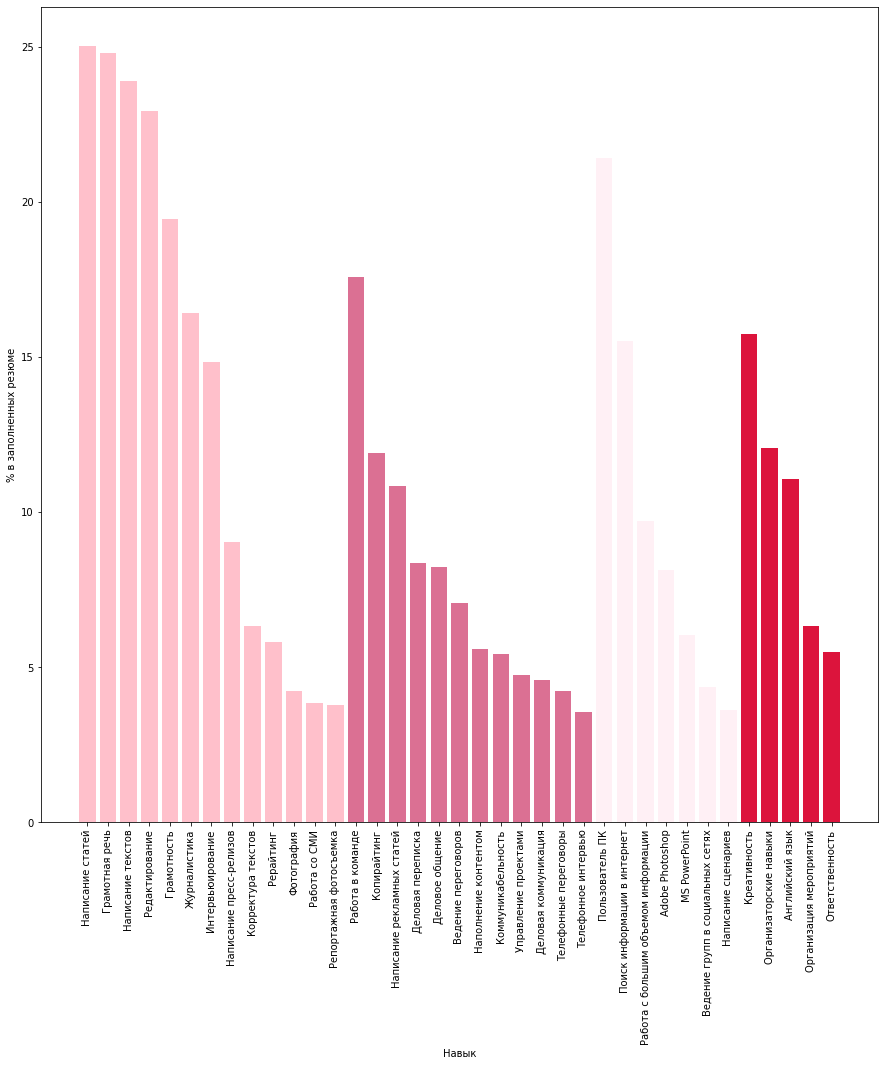

In [535]:
plt.figure(figsize=(15,15))
plt.bar(exp_res_tags['tag'], exp_res_tags['% full'], color = colors)
plt.ylabel(f'% в заполненных резюме')
plt.xlabel('Навык')
plt.xticks(rotation=90) 
plt.savefig('exp_res_tags.png')

In [499]:
exp_res_stat = exp_res_tags.groupby(['expertise']).sum()
exp_res_stat

,count,%,% full
expertise,,,
AE,673,31.790269,50.754148
InnE,913,43.127067,68.853695
IntE,1222,57.723193,92.156863
TE,2393,113.037317,180.467572


In [506]:
exp_res_stat.sum()

count             5201
%           245.677846
% full      392.232278
exp       AEInnEIntETE
dtype: object

In [500]:
exp_res_stat.to_excel('exp_res_stat.xlsx')

In [502]:
exp_res_stat['exp'] = exp_res_stat.index

In [503]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

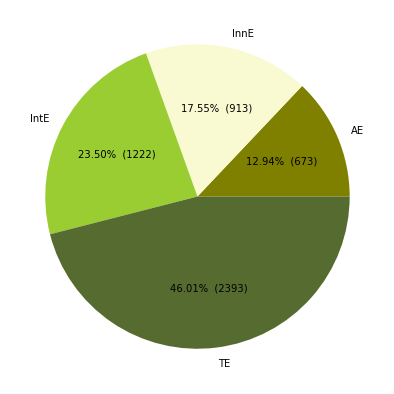

In [505]:
fig = plt.figure(figsize =(10, 7))
plt.pie(exp_res_stat['count'], labels = exp_res_stat['exp'], autopct=make_autopct(exp_res_stat['count']), colors = ['olive', 'lightgoldenrodyellow', 'yellowgreen', 'darkolivegreen'])
plt.savefig('exp_res_stat.png')